Hey team, I'm running a little late on my blog post... here's a work in progress in which I pull pages from Wikipedia about trees and about birds and see if LIME can explain my random forest model.

In [64]:
from urllib.request import urlopen
from urllib.parse import urlencode
from json import loads
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import random

In [121]:
import lime
import numpy as np
import sklearn
import sklearn.feature_extraction as fe
import sklearn.ensemble
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier

In [77]:
os.mkdir('tmp')

In [97]:
birds_raw = requests.get('https://en.wikipedia.org/wiki/List_of_birds_of_the_United_States').content.decode('utf-8')

In [98]:
trees_raw = requests.get('https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_trees').content.decode('utf-8')

In [99]:
def build_corpus(content):
    pages = []
    soup = BeautifulSoup(content, 'html.parser')
    for link in soup.find_all('a'):
        href = link.get('href')
        if href is not None and href.startswith('/wiki/') and not(href.endswith('.jpg')) and href.find(':') == -1 and not(href.startswith('/wiki/List_')):
            fn = 'tmp/' + href[6:] + '.html'
            if not(os.path.exists(fn)):
                print(fn)
                content = requests.get(f'https://en.wikipedia.org{href}').content.decode('utf-8')
                f = open(fn, 'w')
                f.write(content)
                f.close()
            pages.append(fn)
    return pages

In [100]:
birds = build_corpus(birds_raw)

In [101]:
trees = build_corpus(trees_raw)

In [103]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [126]:
docs = []
for fn in birds:
    f = open(fn, 'r')
    content = f.read()
    f.close()
    text = strip_tags(content)
    docs.append({"label": 'birds', "doc": text})
for fn in trees:
    f = open(fn, 'r')
    content = f.read()
    f.close()
    text = strip_tags(content)
    docs.append({"label": 'trees', "doc": text})

In [127]:
len(docs)

1891

In [128]:
df = pd.DataFrame(docs)
df = df.sample(frac=1).reset_index(drop=True)

In [129]:
df.head()

,label,doc
0,birds,\n\n\n\nKingfisher - Wikipedia\ndocument.docum...
1,birds,\n\n\n\nPallas's leaf warbler - Wikipedia\ndoc...
2,birds,\n\n\n\nFan-tailed warbler - Wikipedia\ndocume...
3,trees,\n\n\n\nTsuga canadensis - Wikipedia\ndocument...
4,birds,\n\n\n\nBrewer's blackbird - Wikipedia\ndocume...


In [130]:
s = set(df['label'])
label_map = dict(zip(s, np.arange(len(s))))
df['label_id'] = df['label'].apply(lambda x: label_map[x])

In [131]:
train_proportion = 0.8
p = int(df.shape[0] * train_proportion)
vectorizer = fe.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(df[0:p]['doc'])
test_vectors = vectorizer.transform(df[p:]['doc'])

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, df[0:p]['label_id'].tolist())
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(df[p:]['label_id'].tolist(), pred, average='binary')

0.9938271604938271

In [144]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)
predictions = c.predict_proba(df[p:]['doc'])
preds = []
for i, pred in enumerate(predictions):
    preds.append((df.index[p+i], pred[0]))

In [158]:
df2 = pd.DataFrame(preds, columns=['row_number', 'prediction'])
df2['surprise'] = df2['prediction'].apply(lambda x: 1 - abs(0.5 - x))
df2.sort_values('surprise', inplace=True, ascending=False)
df2.index = np.arange(0, df2.shape[0])

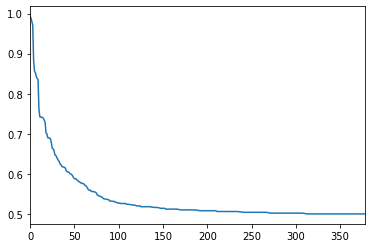

In [161]:
_ = df2['surprise'].plot()

In [162]:
df2.head()

,row_number,prediction,surprise
0,1642,0.493283,0.993283
1,1618,0.511333,0.988667
2,1707,0.519669,0.980331
3,1516,0.528800,0.971200
4,1714,0.383300,0.883300


In [163]:
from lime.lime_text import LimeTextExplainer
d = {}
for i, k in enumerate(label_map.keys()):
    v = label_map[k]
    d[v] = k
explainer = LimeTextExplainer(class_names=d)

In [164]:
idx = 1642

In [165]:
exp = explainer.explain_instance(df.iloc[idx]['doc'], c.predict_proba, num_features=6)

In [166]:
print('Document id: %d' % idx)
x = c.predict_proba([df.iloc[idx]['doc']])
print(x)
print('Probability =', x)
print('True class: %s' % df.iloc[idx]['label'])

Document id: 1642
[[0.49328333 0.50671667]]
Probability = [[0.49328333 0.50671667]]
True class: birds


In [167]:
exp.as_list()

[('Supreme', -0.010968347641469168),
 ('Wisconsin', -0.010680393455699237),
 ('United', -0.010382823506805416),
 ('Louisiana', -0.00994095660173228),
 ('officials', -0.009680712511237448),
 ('Hispanic', -0.0094633299094326)]

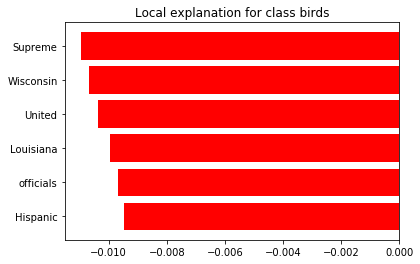

In [168]:
fig = exp.as_pyplot_figure()

In [169]:
exp.class_names = label_map

In [170]:
exp.show_in_notebook(text=True)

In [185]:
df2.tail()

,row_number,prediction,surprise
374,1740,0.0,0.5
375,1739,0.0,0.5
376,1737,0.0,0.5
377,1735,0.0,0.5
378,1701,0.0,0.5


In [186]:
idx = 1740

In [187]:
exp = explainer.explain_instance(df.iloc[idx]['doc'], c.predict_proba, num_features=6)

In [188]:
print('Document id: %d' % idx)
x = c.predict_proba([df.iloc[idx]['doc']])
print(x)
print('Probability =', x)
print('True class: %s' % df.iloc[idx]['label'])

Document id: 1740
[[0. 1.]]
Probability = [[0. 1.]]
True class: birds


In [189]:
exp.as_list()

[('Animalia', 0.03535415819657965),
 ('Chordata', 0.033080335816473606),
 ('species', 0.03154405063414307),
 ('birds', 0.030530399080165575),
 ('Aves', 0.02837112807837642),
 ('Phylum', 0.02752408749494004)]

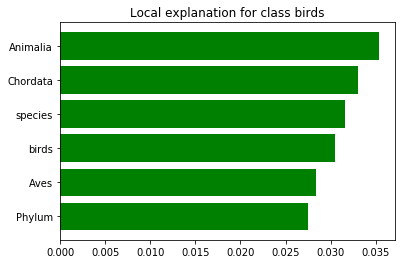

In [190]:
fig = exp.as_pyplot_figure()

In [191]:
exp.class_names = label_map

In [192]:
exp.show_in_notebook(text=True)